# Problem Set 5, due March 8 at 11:59am, mid-day, noon.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [375]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [376]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews = reviews.dropna()


### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [380]:
#How many unique reviews (quotes) are in the reviews dataset?
print "Number of unique reviews (quotes): %i" % len(reviews.quote.unique())
#How many unique reviewers (critics) are in the reviews dataset?
print "Number of unique reviewers (critics): %i" % len(reviews.critic.unique())
#How many unique movies are in the reviews dataset?
print "Number of unique movies in the reviews dataset: %i" % len(reviews.title.unique())
#How many unique movies are in the movies dataset?
print "Number of unique movies in the movies dataset: %i" % len(movies.title.unique())
#How many different publications have reviews in the reviews dataset?
print "Number of different publications have reviews: %i" % len(reviews.publication.unique())
print "Number of reviews: %i" % len(reviews)

Number of unique reviews (quotes): 12149
Number of unique reviewers (critics): 540
Number of unique movies in the reviews dataset: 1715
Number of unique movies in the movies dataset: 9405
Number of different publications have reviews: 64
Number of reviews: 12718


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [5]:
reviewers_freq = {} #create a dictionary

#get the frequency based on the reviewer
for reviewer in reviews.critic.unique():  
    z = reviews.loc[reviews['critic']==reviewer]
    reviewers_freq[reviewer] = len(z);

# add reviewers and frequency of reviews into a dictionary    
from collections import Counter
d= dict(Counter(reviewers_freq.values()))

#grap the top 30 reviewers and total number of reviews
reviews2 = {} #create a second dictionary
import collections
#using a collection to keep track the order items were inserted
d = collections.OrderedDict(sorted(d.items()))
#select the top 30 items 
for k, v in d.items():
    reviews2[k] =  v
    if k == 30:
        break

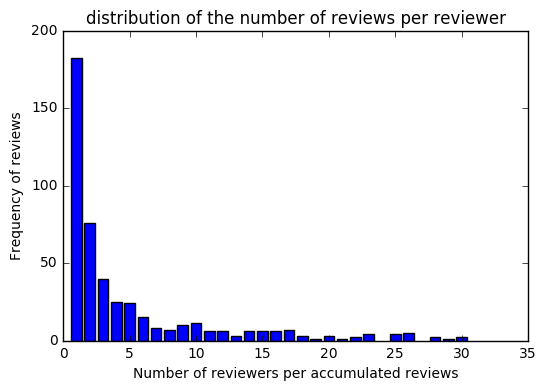

In [383]:
%matplotlib inline 
fig = plt.figure()
ax.tick_params(top='off', right='off')
ax = fig.add_subplot(111)
x = reviews2.keys() #use the dictionary's keys as the horizontal line
y = reviews2.values() #use the dictionary's values as the frequency reviews
plt.bar(x,y,align='center') #plot the graphs
plt.title('distribution of the number of reviews per reviewer') 
plt.xlabel('Number of reviewers per accumulated reviews')
plt.ylabel('Frequency of reviews')
plt.show()

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [6]:
#filter top 30 reviewers
most_30 = reviews.groupby('critic').size().sort_values(ascending=False)[:30]

In [7]:
#format a table to show reviewers, publication, first publication date and last publication date
class ListTable():
    # renders an HTML Table to show mean and standard deviation for each of the variables.
    def _repr_html_(self):
        html = ["<table>"]
        html.append("<tr><th>Reviewer</th><th>Publication</th><th>Review First Date</th><th>Review Last Date</th><th></tr>")
        for index, row in most_30.iteritems():
            reviewer = reviews.loc[reviews['critic']==index]
            html.append("<tr>")
            html.append("<td>{0}</td>".format(index))
            html.append("<td>{0}</td>".format(reviewer.publication.unique()))
            html.append("<td>{0}</td>".format(np.min(reviewer.review_date)))
            html.append("<td>{0}</td>".format(np.max(reviewer.review_date)))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

#calling the class - this will output the table with the related data     
ListTable()

Reviewer,Publication,Review First Date,Review Last Date
Roger Ebert,['Chicago Sun-Times' 'At the Movies'],2000-01-01 00:00:00,2013-06-11 00:00:00
James Berardinelli,['ReelViews'],1800-01-01 00:00:00,2012-02-07 00:00:00
Janet Maslin,['New York Times'],2000-01-01 00:00:00,2010-09-07 00:00:00
Variety Staff,['Variety'],2001-02-13 00:00:00,2012-08-15 00:00:00
Jonathan Rosenbaum,['Chicago Reader'],1988-07-11 00:00:00,2013-10-22 00:00:00
Desson Thomson,['Washington Post'],2000-01-01 00:00:00,2012-10-08 00:00:00
Geoff Andrew,['Time Out'],2005-08-11 00:00:00,2012-04-05 00:00:00
Dave Kehr,['Chicago Reader' 'New York Daily News' 'Chicago Tribune'],2000-01-01 00:00:00,2013-11-20 00:00:00
Kenneth Turan,['Los Angeles Times'],2000-01-01 00:00:00,2013-10-05 00:00:00
Mick LaSalle,['San Francisco Chronicle'],2000-01-01 00:00:00,2009-11-25 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [8]:
movies = movies.dropna() #clean out the movies data 
movies = movies.query('rtAllCriticsRating > 0') #query movies that have had a rating
movie_rating={} #create a dictionary to hold the movie ratings. 

rating = pd.DataFrame({'index':movies.rtAllCriticsRating.index, 'list':movies.rtAllCriticsRating.values})
rating.list = pd.to_numeric(rating.list)

#frame containing unique movies
left_frame = pd.DataFrame({'key':movies.id.unique(), 'title':movies.title, 'year':movies.year})
#frame containing the ratings 
right_frame = pd.DataFrame({'key':rating.index+1, 'rtAllCriticsRating':rating.list})

#create a frame that containts movie's id and related rating 
mergeData = pd.merge(left_frame, right_frame, on='key', how='inner')

#aggreate the average rating by year
data = mergeData.groupby('year').agg({'rtAllCriticsRating': [np.size, np.mean]})

#adding the rating based on the movie
for index, row in data.iterrows():
    movie_rating[index] = round(row['rtAllCriticsRating'][1], 2)


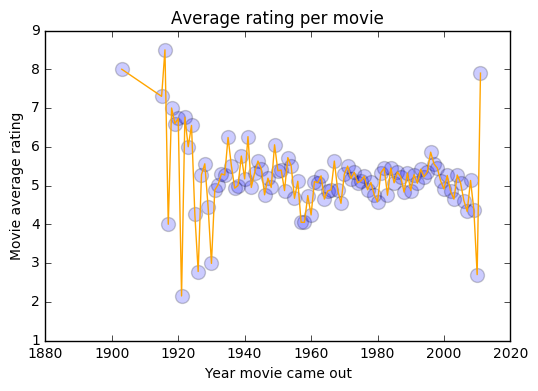

In [51]:

#Set the x and y coordinates based on the value added in the dictionary
x, y = movie_rating.keys(), movie_rating.values()
plt.scatter(x, y, alpha=.2, s=100) #plot the scattered data points 
plt.plot(x, y, c='orange') #plot the line connecting the dots
# Add a title.
plt.title("Average rating per movie")
# Add labels to both the Y and X axis
plt.ylabel('Movie average rating')
plt.xlabel('Year movie came out')
plt.show() #show the  scatter plot

Based on the graphic, it appears that the average rating fluctuates every year. There is not a specific trend, but rather a constant variation of rating being up one year and down the next or vice-versa. 

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [441]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text is
machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
[[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
[u'learning', u'machine', u'rocks', u'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [384]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
from sklearn.feature_extraction.text import CountVectorizer
def make_xy(reviews, vectorizer=None):
    if vectorizer == None:
        vectorizer = CountVectorizer(min_df = 0) 
        
    text = reviews.quote.values
    vectorizer.fit(text)
    X = vectorizer.transform(text)
    X = X.toarray()
    Y = reviews.fresh.apply(lambda x: 1 if x == 'fresh' else 0)
    return X, Y


In [385]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [387]:
from sklearn.model_selection import train_test_split
# split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X,Y)  

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [388]:
from sklearn.naive_bayes import MultinomialNB
#call Nayves Baye's multioniomal funciton 
clf = MultinomialNB()
# call the fitted model 
fitted_model = clf.fit(X_train, y_train)
#get the test and training scores
test_score = fitted_model.score(X_test,y_test)
training_score = fitted_model.score(X_train, y_train)

print 'Test data accuracy: ' , test_score*100
print 'Training data accuracy: ' ,training_score*100

Test data accuracy:  78.4591194969
Training data accuracy:  92.7762633676


The gap between the training and test accuracy indicates the amount of overfitting. The test data shows a smaller validation accuracy compared to the training accuracy, indicating strong overfitting. This tells us that we either need to collect more data or we may need to increase the number of parameters for this model. 

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [452]:
#assuming train and test set were slipt
def main():
    # prepare model
    summaries = summarizeByClass(trainingSet)
    # test model
    predictions = getPredictions(summaries, testSet)
    accuracy = getAccuracy(testSet, predictions)
    print('Accuracy: {0}%').format(accuracy)

def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classValue, instances in separated.iteritems():
        summaries[classValue] = summarize(instances)
    return summaries
 
def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent
 
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.iteritems():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities

def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.iteritems():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel
 
def getPredictions(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(summaries, testSet[i])
        predictions.append(result)
    return predictions
 
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector)
    return separated

def summarize(dataset):
    summaries = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
    del summaries[-1]
    return summaries

def mean(numbers):
    return sum(numbers)/float(len(numbers))
 
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)





---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [389]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X_test,y_test)

C:\Users\pierreau\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


-5314.2486289069948

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [390]:
from sklearn.model_selection import cross_val_score

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

#loop through the list of alphas
for alpha in alphas:
    for min_df in min_dfs: #loop through the min_df values
        #create a document-term matrix
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        Y = Y.values #only the values of the series
        clf = MultinomialNB(alpha=alpha)
        scores =  cross_val_score(clf, X, Y,scoring=log_likelihood) # use use the default 3-fold cross validation
        #find the best_alpha and best_min_df based on the genered cross_val_score
        if scores.mean() > max_loglike:
            best_alpha = alpha
            best_min_df = min_df
            max_loglike = scores.mean()
        
  

In [391]:

print 'alpha: ', best_alpha
print 'min_df: ', best_min_df


alpha:  5
min_df:  0.001


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [392]:
vectorizer = CountVectorizer(min_df=best_min_df) #Instatiate a new CountVectorizer with best_min_df
#get the quote values
text = reviews.quote.values
vectorizer.fit(text) #fit our estimator to the data
X = vectorizer.transform(text) #transform 
X = X.toarray() #Get the Array content of X
X, Y = make_xy(reviews, vectorizer) # Call make_xy
Y = Y.values #get the values of the series

X_train, X_test, y_train, y_test = train_test_split(X, Y) # Split data into test and training sets
clf = MultinomialNB(alpha = best_alpha) # Create a new classifier, using the best alpha from above
clf.fit(X_train, y_train) # Fit the model

#evaluating the predictiv analysis 
predicted_test = clf.predict(X_test)

print 'Test data accuracy: ' , clf.score(X_test, y_test)
print 'Training data accuracy: ' ,clf.score(X_train, y_train)

Test data accuracy:  0.74748427673
Training data accuracy:  0.792199622562


By default, a model is overfit if it performs better on the training data than the test data. That said, the gap between the training and test accuracy is still showing an amount of overfitting when compared to 2.3. However, this time the overfitting level is not as strong as what was shown on 2.3. The discrepancy between the test data and training data highlights the bias/variance tradeoff. The difference between the accuracy in 2.3 and this model tells us that we have collected more data for this analysis compared to 2.3. Thus, this model compared to 2.3 is a lot more accurate and the model in 3.3 does a better job when trying to avoid overfitting. 

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [4]:
#Enter your code here-

*enter your observations here*

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [436]:
#create a classifier using Naive Bayes
vectorizer = CountVectorizer(min_df=best_min_df) 
text = reviews.quote.values
vectorizer.fit(text)
X = vectorizer.transform(text)
X = X.toarray()
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X, Y)

#get a list of names
names = vectorizer.get_feature_names()
#return an array with 1's on the diagonal
eye_matrix = np.eye(len(names)) #np.identity uses np.eye. 
#calculate the propabilty based on 
probs = clf.predict_proba(eye_matrix)
fresh = probs[:,1] #get fresh words probabilty
rotten = probs[:,0] #get rotten words probability


words_fresh = pd.DataFrame({'fresh': fresh, 'words': names})
words_rotten = pd.DataFrame({'rotten': rotten, 'words':names})
top_ten_fresh_words = words_fresh.sort('fresh', ascending=False)
top_ten_rotten_words = words_rotten.sort('rotten', ascending=False)

# top 10 fresh and rotten words
print top_ten_fresh_words.head(10)
print '\n'
print top_ten_rotten_words.head(10)

         fresh          words
476   0.905253        delight
1186  0.903351    masterpiece
1998  0.876867       touching
1003  0.875156    intelligent
1535  0.874787           rare
1879  0.870974         superb
1569  0.870974     remarkable
1859  0.867160       stunning
2183  0.865570          witty
669   0.864489  extraordinary


        rotten           words
2053  0.882942   unfortunately
1077  0.856529            lame
1451  0.843561       pointless
2055  0.833531      uninspired
208   0.828017           bland
2054  0.806674         unfunny
519   0.806674  disappointment
1983  0.801753        tiresome
555   0.801063            dull
1625  0.785364           sadly


C:\Users\pierreau\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\pierreau\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The result above shows that words like delight and masterpiece appears 90% of the time to predict a fresh review. On the other hand, words like unfortunately an lame appears over 85% of the time to predict rotten reivews. 

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [437]:
probabilities = clf.predict_proba(X) # predict probabilities
df_poor_performance = pd.DataFrame({'probality_rotten': probabilities[:,0], 'probability_fresh': probabilities[:,1], 'fresh': Y, 'quote': reviews['quote']})
df_mispredict_rotten = df_poor_performance[df_poor_performance.fresh==0] #mispredict rotten to fresh
df_mispredict_fresh = df_poor_performance[df_poor_performance.fresh==1] #mispredict fresh to rotten
df_mispredict_fresh.sort(['probability_fresh'], ascending=True, inplace=True)
df_mispredict_rotten.sort(['probality_rotten'], ascending=True, inplace=True)

print "Top five mispredicted fresh reviews: \n"
print df_mispredict_rotten.quote[:5].values
print "\n"
print "Top five mispredicted rotten reviews: \n"
print df_mispredict_fresh.quote[:5].values


C:\Users\pierreau\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\pierreau\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Top five mispredicted fresh reviews: 

[ 'It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.'
 "It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow."
 "The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece."
 'The Disney organization is worst when it makes "family entertainment" and best when it sticks to pure, simple, charming fantasy.'
 'This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.']


Top five mispredicted rotten reviews: 

[ "Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when t

In [438]:
example = ["This movie is not remarkable, touching, or superb in any way."]
x = vectorizer.transform(example)
x = x.tocsc()
probs = clf.predict_proba(x)
print probs

[[ 0.01468006  0.98531994]]


It appears that our model does not perform well when the text contains a negation such as in this case, "not remarkable" and "remarkable" are treated the same because the negation ("not") has been seperated from the adjective ("remarkable") in the bag of words. Just looking at the sentence at face value, we would exect the review provided to be "rotten", however, our mdeld predicted to be a "fresh" review with a probabilty of 98%. This is because of the presence of words associated with "Fresh" such as "superb", "touching", and "remarkable". 


## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [302]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

In [303]:
#convert to a dataframe 
bdata_df = pd.DataFrame(bdata.data, columns=bdata.feature_names)
# descriptions
bdata_df['MEDV'] = bdata.target
bdata_df['MEDV'] = bdata_df['MEDV'].where(pd.notnull(bdata_df['MEDV'])).dropna()
bdata_df['CRIM'] = bdata_df['CRIM'].where(pd.notnull(bdata_df['CRIM'])).dropna()

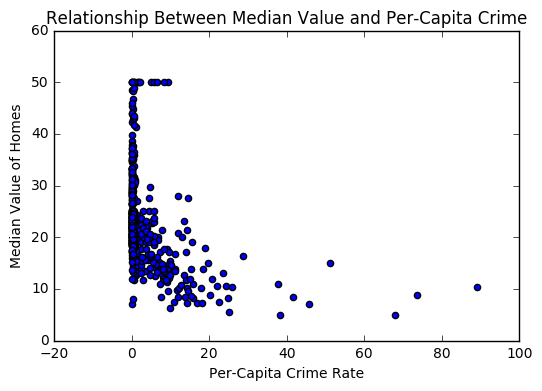

In [304]:
Y = bdata_df['MEDV'] #Vertical component takes on the median value
X = bdata_df['CRIM'] #Horizontal component takes on the CRIME value

plt.title('Relationship Between Median Value and Per-Capita Crime')
plt.xlabel('Per-Capita Crime Rate')
plt.ylabel('Median Value of Homes')
plt.scatter(X, Y)
plt.show()

In [305]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.16
"""
# import libraries to get the mean squared error
from sklearn.metrics import mean_squared_error

def compute_rmse(predictions, yvalues):
    # taking the square root of the mean squared error 
    rmse = np.sqrt(mean_squared_error(predictions,yvalues))
    return rmse

In [333]:
#convert to a dataframe 
bdata_df = pd.DataFrame(bdata.data, columns=bdata.feature_names)
bdata_df['MEDV'] = bdata.target

columns = bdata_df.columns.tolist()
# Filter all the columns excetp "MEDV"
columns = [c for c in columns if c in ["RM"]]

X = bdata_df[columns] #contains average number of rooms per house
y = bdata_df['MEDV'] #contains the median price

# Generate the training set.  Set random_state to be able to replicate results.
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.34, random_state=2000)

In [334]:
#Import the linearregression model.
from sklearn.linear_model import LinearRegression

# Initialize the model class.
model = LinearRegression()

# Fit the model to the training data.
model.fit(X_train, y_train)    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [335]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

#generate a prediction using the RMSE
print "Training prediction:", compute_rmse(pred_train, y_train)
print "Test prediction:", compute_rmse(pred_test, y_test)

Training prediction: 6.37678586892
Test prediction: 7.01820026963


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

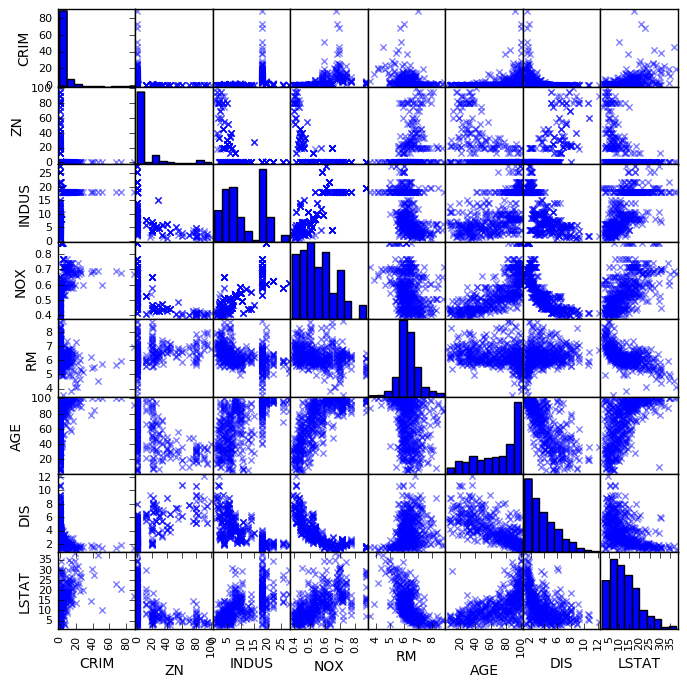

In [416]:
bdata_df = pd.DataFrame(bdata.data, columns=bdata.feature_names)

# Get all the columns from the dataframe.
columns = bdata_df.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c  in ["CRIM", "ZN", "INDUS", "LSTAT", "NOX", "RM", "AGE","DIS"]]

bdata_df[columns]

# using scatter matrix to show correlation between the 8 features selected above
axes = pd.tools.plotting.scatter_matrix(bdata_df[columns], figsize=[8,8],marker='x')

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [187]:
columns = bdata_df.columns.tolist()

# Filter all the columns excetp "MEDV"
columns = [c for c in columns if c not in ["MEDV"]]

bdata_df[columns]
# Generate the training set.  Set random_state to be able to replicate results.
X_train =  bdata_df[columns].sample(frac=0.66, random_state=200)
# Select anything not in the training set and put it in the testing set.
X_test = bdata_df.loc[~bdata_df.index.isin(bdata_train.index)]

In [191]:
#calculate PCA for 12 components
from sklearn.decomposition import PCA
pca = PCA(n_components=12) 
pca.fit(X_train) 
pca

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [192]:
eig_vals= pca.explained_variance_ratio_
print eig_vals

[  8.00138401e-01   1.69509550e-01   2.02785278e-02   6.86965182e-03
   1.55638737e-03   8.10241544e-04   4.46843279e-04   2.64565278e-04
   8.74606511e-05   3.02983370e-05   6.57895400e-06   1.41398457e-06]


In [193]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

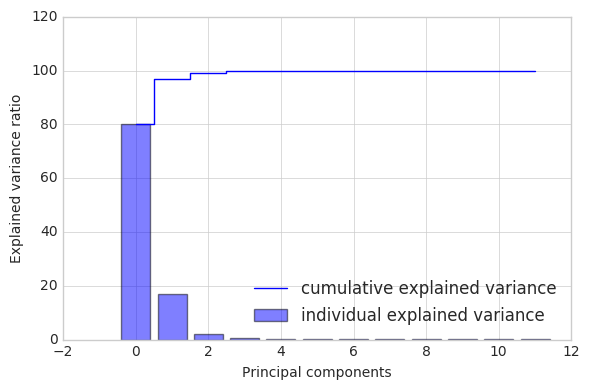

In [194]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(12), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(12), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [409]:
#convert to a dataframe 
bdata_df = pd.DataFrame(bdata.data, columns=bdata.feature_names)
# descriptions
bdata_df['MEDV'] = bdata.target
columns = bdata_df.columns.tolist()

# Filter all the columns excetp "MEDV"
columns = [c for c in columns if c not in ["MEDV"]]
 
X = bdata_df[columns] #use all coloumns except MEDV
y = bdata_df['MEDV']

# Generate the training set.  Set random_state to be able to replicate results.
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.34, random_state=2000)

In [410]:
x_reduced = PCA(n_components=2).fit_transform(X_train)

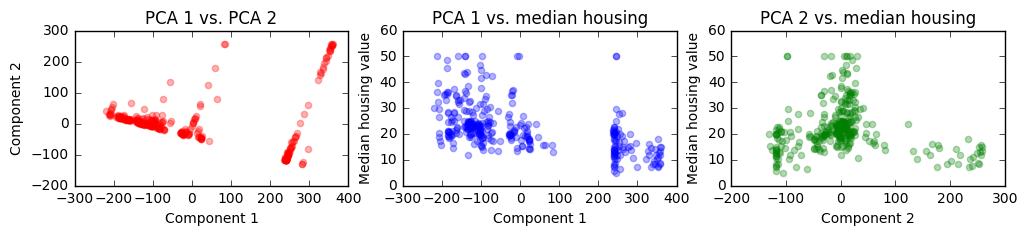

In [411]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
alpha_var = 0.3
ax[0].scatter(x_reduced[:,0],x_reduced[:,1],color='red', alpha = alpha_var, label='0')
ax[0].set_xlabel('Component 1')
ax[0].set_ylabel('Component 2')
ax[0].set_title('PCA 1 vs. PCA 2')
   
ax[1].scatter(x_reduced[:,0], y_train, color='blue', alpha = alpha_var, label='1')
ax[1].set_xlabel('Component 1')
ax[1].set_ylabel('Median housing value')
ax[1].set_title('PCA 1 vs. median housing')

ax[2].scatter(x_reduced[:,1], y_train, color='green',alpha = alpha_var, label='2')
ax[2].set_xlabel('Component 2')
ax[2].set_ylabel('Median housing value')
ax[2].set_title('PCA 2 vs. median housing')
                
plt.show()

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [417]:
model = LinearRegression()
x_reduced = PCA(n_components=2).fit_transform(X_train)

# Fit the model to the training data.
model.fit(x_reduced[:,0].reshape(-1,1), y_train)      

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [420]:
pred_train = model.predict(x_reduced[:,0].reshape(-1,1))
print "Test prediction:", compute_rmse(pred_train, y_train)

Test prediction: 7.77460411713


In [421]:
x_reduced_test = PCA(n_components=2).fit_transform(X_test)

# Fit the model to the training data.
model.fit(x_reduced_test[:,0].reshape(-1,1), y_test)     

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [422]:
pred_test = model.predict(x_reduced_test[:,0].reshape(-1,1))
print "Test prediction:", compute_rmse(pred_test, y_test)

Test prediction: 8.52781323737


For question 4.1,  we got the following prediction results: 
 - Training prediction: 6.37678586892
 - Test prediction: 7.01820026963
    
While for 4.5, we got the following prediction results: 
 - Training prediction: 7.77460411713
 - Test prediction: 8.52781323737

RMSE is understood as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Ideally, lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction.

Based on the explaination above, 4.1 had a lower RMSE when compared to 4.5. Thus, the model used in 4.1 is better measure to better predicts the response. In other words, we can say that in 4.1 the predicted value is closer to the actual value when compared to 4.5. 